## Titanic Competition for GCI 2019 Winter 7th Place Solution
2020/01/19

Solution Summary

- 前処理/特徴量エンジニアリング
  - 欠損値の補完
  - ラベルエンコーディング
  - 特徴量作成 (FamilySize, Title_Group等)
  - テキストデータから特徴抽出 (Name, Ticket)
  - カウントエンコーディング
  - ターゲットエンコーディング

- モデル
  - LightGBM (特に工夫したところはなし)
  - XGBoost (特に工夫したところはなし)
  - Neural Network (Keras利用、再現性確保できず。。)
  
- 予測
  - 3つのモデルの予測結果(確率)の算術平均

## 1. Load Module

In [1]:
!pip install lightgbm
!pip install xgboost

In [2]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Activation, Add, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [5]:
# Set pandas max_columns and max_rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

## 2. Load Data

In [6]:
# Set base_dir
base_dir = '/root/userspace/Workspace/competition1/'

In [7]:
# Read CSV file
df_train = pd.read_csv(base_dir + 'input/train.csv')
df_test = pd.read_csv(base_dir + 'input/test.csv')
df_sub = pd.read_csv(base_dir + 'gender_submission.csv')

# Confirm
print(df_train.shape, df_test.shape, df_sub.shape)

(891, 12) (418, 11) (418, 2)


In [8]:
# Merge df_train and df_test
df_alldata = pd.concat([df_train, df_test], sort=False)
df_alldata.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 3. Check Data

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [12]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 4. Preprocess and Feature Engineering

### 4-1. Impute Missing Values

In [13]:
### Age
Age_by_Pclass = list(df_alldata.groupby('Pclass')['Age'].mean())

def complement_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return Age_by_Pclass[0]
        elif Pclass == 2:
            return Age_by_Pclass[1]
        else:
            return Age_by_Pclass[2]
    else:
        return Age

df_train['Age'] = df_train[['Age','Pclass']].apply(complement_age, axis = 1)
df_test['Age'] = df_test[['Age', 'Pclass']].apply(complement_age, axis = 1)

In [14]:
### Embarked
df_train['Embarked'].fillna('C', inplace=True)
df_test['Embarked'].fillna('C', inplace=True)

In [15]:
### Fare (only one record of df_test)
Fare_missing_Id = list(df_test['PassengerId'][df_test['Fare'].isnull() == True])
Fare_missing_Pclass = list(df_test['Pclass'][df_test['Fare'].isnull() == True])
print('Fare missing ID:', Fare_missing_Id)
print('Fare missing Pclass:', Fare_missing_Pclass)

Fare_by_Pclass = list(df_alldata.groupby('Pclass')['Fare'].mean())
print(Fare_by_Pclass)

df_test.loc[df_test['PassengerId'] == Fare_missing_Id[0], 'Fare'] = Fare_by_Pclass[Fare_missing_Pclass[0]-1]

# Confirm
df_test[df_test['PassengerId'] == Fare_missing_Id[0]]

Fare missing ID: [1044]
Fare missing Pclass: [3]
[87.5089916408668, 21.1791963898917, 13.302888700564969]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,13.302889,NaN,S


In [16]:
### Cabin
df_train.fillna({'Cabin':'9999'}, inplace=True)
df_test.fillna({'Cabin':'9999'}, inplace=True)

In [17]:
# Confirm df_train
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [18]:
# Confirm df_test
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### 4-2. Label Encoding

In [19]:
### Sex
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

In [20]:
### Embarked
df_train['Embarked'] = df_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
df_test['Embarked'] = df_test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

### 4-3. Create New Features

In [21]:
### FamilySize
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [22]:
### IsAlone (Whether or not to board alone)
df_train['IsAlone'] = 0
df_test['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

In [23]:
### Title_Group

# Extract Title
df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Set Title_Group list
Mr = ['Mr']
Crew1 = ['Don', 'Rev', 'Capt']
Crew2 = ['Major', 'Col', 'Dr']
Women_Masters = ['Mrs', 'Miss', 'Master']
Affluence = ['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'Countess', 'Jonkheer']

# Create Title_Group Feature
dataset = [df_train, df_test]
for train_set in dataset:
    train_set['Title_Group'] = 0
    train_set['Title_Group'] = np.where(train_set['Title'].isin(Mr), 0, train_set['Title_Group'])
    train_set['Title_Group'] = np.where(train_set['Title'].isin(Crew1), 1, train_set['Title_Group'])
    train_set['Title_Group'] = np.where(train_set['Title'].isin(Crew2), 2, train_set['Title_Group'])
    train_set['Title_Group'] = np.where(train_set['Title'].isin(Women_Masters), 3, train_set['Title_Group'])
    train_set['Title_Group'] = np.where(train_set['Title'].isin(Affluence), 4, train_set['Title_Group'])
    train_set['Title_Group'] = train_set['Title_Group'].astype(int)

In [24]:
### CabinBool (Cabin is blank or not)
df_train["CabinBool"] = (df_train["Cabin"]=='9999').astype(int)
df_test["CabinBool"] = (df_test["Cabin"]=='9999').astype(int)

### 4-4. Extract Features from Text Data

In [25]:
#-------------------
# 誤ったコード
#-------------------
"""
# Merge df_train & df_test
df_train['data_set'] = 'train'
df_test['data_set']  = 'test'
df_alldata = pd.concat([df_train, df_test])
"""

"\n# Merge df_train & df_test\ndf_train['data_set'] = 'train'\ndf_test['data_set']  = 'test'\ndf_alldata = pd.concat([df_train, df_test])\n"

In [26]:
#-------------------
# 修正後のコード
#-------------------
# Merge df_train & df_test
df_train['data_set'] = 'train'
df_test['data_set']  = 'test'
df_alldata = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [27]:
# Define function (get_text_features)
def get_text_features(text_column, text_column_name):
    vectorizer = TfidfVectorizer(min_df=1, max_df=95)
    tsvd = TruncatedSVD(n_components=64, random_state=227)
    
    tfidf_col = vectorizer.fit_transform(text_column.values)
    svd_col = tsvd.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col).astype(np.float16)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(text_column_name))
    
    return svd_col

In [28]:
# Get Text Features
text_col = ['Name', 'Ticket']
for col in text_col:
    text_features = get_text_features(df_alldata[col], col)
    df_alldata = pd.merge(df_alldata, text_features, right_index=True, left_index=True)        

### 4-5. Count Encoding

In [29]:
count_enc_list = ['Pclass', 'Sex', 'Embarked', 'FamilySize', 'IsAlone', 'Title_Group', 'CabinBool']
for col in count_enc_list:
    grouped = df_alldata.groupby(col).size().reset_index(name=col+'_count')
    df_alldata = df_alldata.merge(grouped, how = "left", on = col)

### 4-6. Target Encoding

In [30]:
# Split data set
df_train = df_alldata[df_alldata['data_set']=='train']
df_test  = df_alldata[df_alldata['data_set']=='test']

print(df_train.shape, df_test.shape)

(891, 153) (418, 153)


In [31]:
### Target Encoding for df_train

# Set target_enc_list
target_enc_list = ["FamilySize", "Embarked", "Pclass", "CabinBool", "Title_Group"]

# number of Fold
fold_num = 5

# fix random seed for reproducibility
seed = 227
np.random.seed(seed)

# Create column for target encoding
for col in target_enc_list:
    df_train[col+'_target'] = np.NaN

# Defile kfold cross validation
kfold = KFold(n_splits=fold_num, shuffle=True, random_state=seed)

for fold_index, (train_index, valid_index) in enumerate(kfold.split(df_train)):
    for col in target_enc_list:
        target_mean = df_train.iloc[train_index].groupby(col).Survived.mean()
        df_train[col+'_target'].iloc[valid_index] = df_train.iloc[valid_index][col].map(target_mean)

In [32]:
### Target Encoding for df_test

# Create column for target encoding
for col in target_enc_list:
    df_test[col+'_target'] = np.NaN

# Create target encoding
for col in target_enc_list:
    target_mean = df_train.groupby(col).Survived.mean()
    df_test[col+'_target'] = df_test[col].map(target_mean)

In [33]:
# Confirm shape
print(df_train.shape, df_test.shape)

(891, 158) (418, 158)


## 5. Train / Evaluate / Predict

### 5-1. Create train and test data

In [34]:
# Create x_train、 y_train、 x_test
drop_col = ['Name', 'Age', 'Cabin', 'Ticket','SibSp','Parch', 'Fare', 'Title', 'PassengerId', 'Survived', 'data_set']
x_train = df_train.drop(drop_col, axis=1)
y_train = df_train['Survived']
x_test = df_test.drop(drop_col, axis=1)

# Confirm
print(x_train.shape, y_train.shape, x_test.shape)

(891, 147) (891,) (418, 147)


### 5-2. LightGBM

In [35]:
# Set parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.005,
    'max_depth': 6,
    'bagging_freq': 1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'verbose': -1,
    'nthread': -1,
}

In [36]:
# number of Fold
fold_num = 5

# Initialize y_preds
y_preds_lgbm = np.zeros(x_test.shape[0])

# fix random seed for reproducibility
seed = 227
np.random.seed(seed)

# Defile kfold cross validation
kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
cvscores_auc = []
cvscores_acc = []

In [37]:
%%time
for fold_index, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):
    
    # Create dataset for LightGBM
    lgb_train = lgb.Dataset(x_train.iloc[train_index], y_train.iloc[train_index])
    lgb_valid = lgb.Dataset(x_train.iloc[valid_index], y_train.iloc[valid_index])

    # Train
    print('\n Train LightGBM: ', fold_index+1)
    model_lgbm = lgb.train(params=lgb_params,
                       train_set=lgb_train,
                       valid_sets=[lgb_train, lgb_valid],
                       num_boost_round=10000,
                       early_stopping_rounds=500,
                       verbose_eval=1000,
                      )
    
    # Evaluate
    y_valid_preds = model_lgbm.predict(x_train.iloc[valid_index], num_iteration=model_lgbm.best_iteration)
    valid_score_auc = roc_auc_score(y_train.iloc[valid_index], y_valid_preds)
    valid_score_acc = accuracy_score(y_train.iloc[valid_index], np.round(y_valid_preds).astype(np.int8))
    print('valid score AUC :', "%.4f" % valid_score_auc)
    print('valid score Accuracy :', "%.4f" % valid_score_acc)
    cvscores_auc.append(valid_score_auc)
    cvscores_acc.append(valid_score_acc)
        
    # Predict
    y_preds_lgbm += model_lgbm.predict(x_test, num_iteration=model_lgbm.best_iteration) / fold_num
    
# Print CV
print('-'*10)
print('Cross Validation AUC: ',      "%.4f (+/- %.2f%%)" % (np.mean(cvscores_auc), np.std(cvscores_auc)))
print('Cross Validation Accuracy: ', "%.4f (+/- %.2f%%)" % (np.mean(cvscores_acc), np.std(cvscores_acc)))
print('-'*10)



 Train LightGBM:  1
Training until validation scores don't improve for 500 rounds
[1000]	training's binary_logloss: 0.0892099	valid_1's binary_logloss: 0.41656
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.193776	valid_1's binary_logloss: 0.400262
valid score AUC : 0.8855
valid score Accuracy : 0.8268

 Train LightGBM:  2
Training until validation scores don't improve for 500 rounds
[1000]	training's binary_logloss: 0.0854987	valid_1's binary_logloss: 0.478937
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.162694	valid_1's binary_logloss: 0.466289
valid score AUC : 0.8478
valid score Accuracy : 0.7989

 Train LightGBM:  3
Training until validation scores don't improve for 500 rounds
[1000]	training's binary_logloss: 0.0923705	valid_1's binary_logloss: 0.362026
Early stopping, best iteration is:
[1149]	training's binary_logloss: 0.073763	valid_1's binary_logloss: 0.361037
valid score AUC : 0.9045
valid score Accuracy : 0.8708

 Train Light

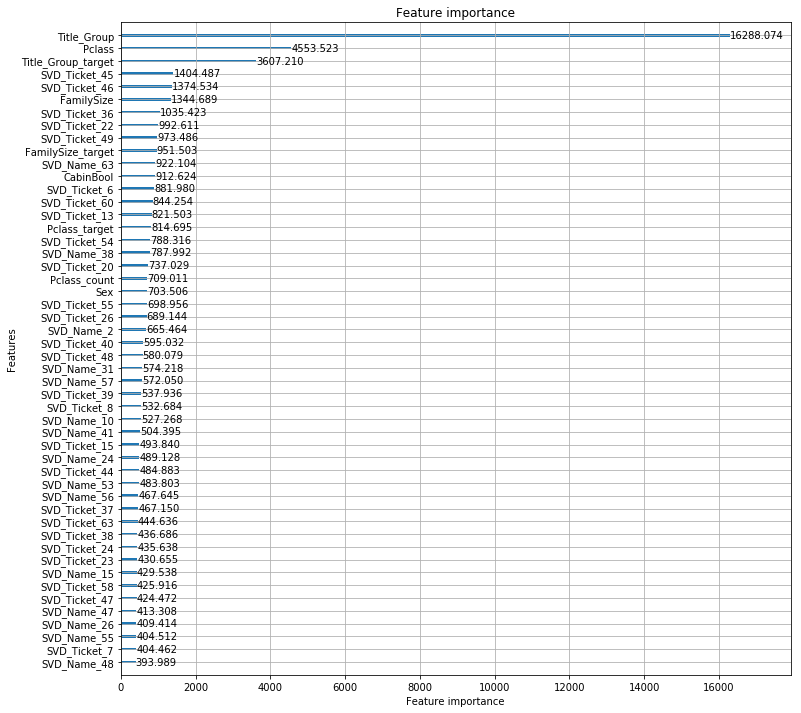

In [38]:
# Visualize Feature Importance of LightGBM
lgb.plot_importance(model_lgbm, grid=True, max_num_features=50, importance_type='gain', figsize=(12, 12))
plt.show()

In [39]:
# Check y_preds
y_preds_lgbm[:10]

array([0.08486275, 0.51858806, 0.05418629, 0.08692173, 0.60612318,
       0.0839291 , 0.62750729, 0.28325121, 0.48687333, 0.16110759])

In [40]:
# Check y_preds describe
pd.DataFrame(y_preds_lgbm).describe().T

,count,mean,std,min,25%,50%,75%,max
0,418.0,0.374143,0.329612,0.030488,0.091061,0.203746,0.682299,0.964224


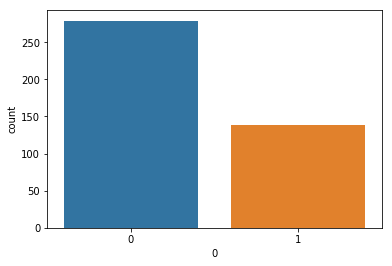

0    0.667464
1    0.332536
dtype: float64


In [41]:
# Distribution of y_preds
y_preds_lgbm_int = np.round(y_preds_lgbm).astype(np.int8)
sns.countplot(x=0, data=pd.DataFrame(y_preds_lgbm_int))
plt.show()

print(pd.Series(y_preds_lgbm_int).value_counts(normalize=True))

### 5-3. XGBoost

In [42]:
# Set XGBoost parameters
xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.005,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

In [43]:
# number fo CV
fold_num = 5

# Initialize y_pred
y_preds_xgb = np.zeros(x_test.shape[0])

# fix random seed for reproducibility
seed = 227
np.random.seed(seed)

# Defile kfold cross validation
kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
cvscores_auc = []
cvscores_acc = []

In [44]:
%%time
for fold_index, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):

    # Set Data for XGBoost
    xgb_train = xgb.DMatrix(x_train.iloc[train_index], y_train.iloc[train_index])
    xgb_valid = xgb.DMatrix(x_train.iloc[valid_index], y_train.iloc[valid_index])

    # Set watchlist
    watchlist = [(xgb_train, 'train'), (xgb_valid, 'valid')]

    # Train
    print('\n Train XGBoost: ', fold_index+1)
    model_xgb = xgb.train(params=xgb_params,
                           dtrain=xgb_train,
                           evals=watchlist,
                           num_boost_round=10000,
                           early_stopping_rounds=500,
                           verbose_eval=500,
                          )    

    # Evaluate
    y_valid_preds = model_xgb.predict(xgb.DMatrix(x_train.iloc[valid_index]), ntree_limit=model_xgb.best_ntree_limit)
    valid_score_auc = roc_auc_score(y_train.iloc[valid_index], y_valid_preds)
    valid_score_acc = accuracy_score(y_train.iloc[valid_index], np.round(y_valid_preds).astype(np.int8))
    print('valid score AUC :', "%.4f" % valid_score_auc)
    print('valid score Accuracy :', "%.4f" % valid_score_acc)
    cvscores_auc.append(valid_score_auc)
    cvscores_acc.append(valid_score_acc)
        
    # Predict
    y_preds_xgb += model_xgb.predict(xgb.DMatrix(x_test), ntree_limit=model_xgb.best_ntree_limit).reshape(-1) / fold_num
    
# Print CV
print('-'*10)
print('Cross Validation AUC: ',      "%.4f (+/- %.2f%%)" % (np.mean(cvscores_auc), np.std(cvscores_auc)))
print('Cross Validation Accuracy: ', "%.4f (+/- %.2f%%)" % (np.mean(cvscores_acc), np.std(cvscores_acc)))
print('-'*10)


 Train XGBoost:  1
[0]	train-logloss:0.689884	valid-logloss:0.690619
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 500 rounds.
[500]	train-logloss:0.166401	valid-logloss:0.394493
[1000]	train-logloss:0.074336	valid-logloss:0.407153
Stopping. Best iteration:
[568]	train-logloss:0.145467	valid-logloss:0.392822

valid score AUC : 0.8823
valid score Accuracy : 0.8380

 Train XGBoost:  2
[0]	train-logloss:0.689894	valid-logloss:0.690781
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 500 rounds.
[500]	train-logloss:0.161915	valid-logloss:0.469935
Stopping. Best iteration:
[401]	train-logloss:0.201517	valid-logloss:0.466252

valid score AUC : 0.8457
valid score Accuracy : 0.7877

 Train XGBoost:  3
[0]	train-logloss:0.690012	valid-logloss:0.690765
Multiple eval metrics have been passed: 'valid-logloss' will 

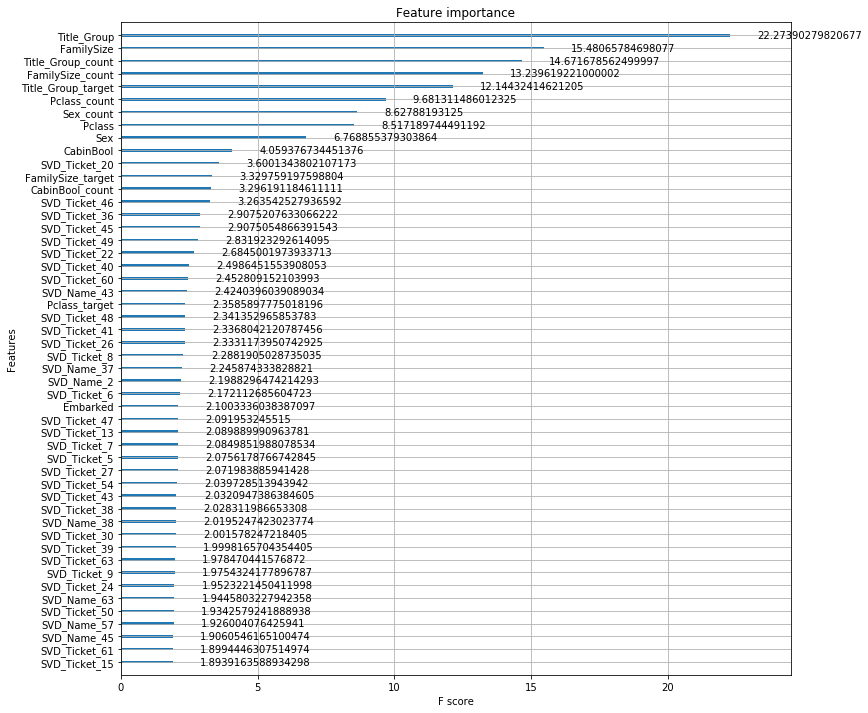

In [45]:
# Visualize Feature Importance of XGBoost
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
xgb.plot_importance(model_xgb, grid=True, max_num_features=50, importance_type='gain', ax=ax)
plt.show()

In [46]:
# Check y_preds
y_preds_xgb[:10]

array([0.09080707, 0.58256311, 0.06702716, 0.08189694, 0.62870466,
       0.09172087, 0.65690503, 0.25569126, 0.5046407 , 0.17663131])

In [47]:
# Check y_preds describe
pd.DataFrame(y_preds_xgb).describe().T

,count,mean,std,min,25%,50%,75%,max
0,418.0,0.382562,0.329324,0.046546,0.101884,0.219166,0.689006,0.957726


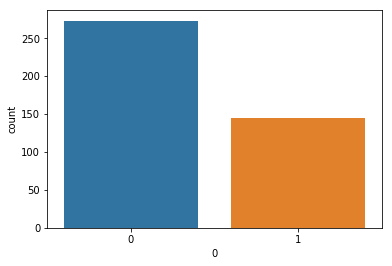

0    0.65311
1    0.34689
dtype: float64


In [48]:
# Distribution of y_preds
y_preds_xgb_int = np.round(y_preds_xgb).astype(np.int8)
sns.countplot(x=0, data=pd.DataFrame(y_preds_xgb_int))
plt.show()

print(pd.Series(y_preds_xgb_int).value_counts(normalize=True))

### 5-4. Neural Network

In [49]:
# Learning rate scheduler
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.00005
    elif epoch > 50:
        lrate = 0.0001
    elif epoch > 25:
        lrate = 0.0005
    return lrate

In [50]:
# One-Hot Eocnding
dummies_column = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'FamilySize', 'CabinBool', 'Title_Group']
x_train_nn = pd.get_dummies(x_train, columns=dummies_column)
x_test_nn  = pd.get_dummies(x_test,  columns=dummies_column)

# Confirm
print(x_train_nn.shape, x_test_nn.shape)
x_train_nn.head()

(891, 166) (418, 166)


,SVD_Name_0,SVD_Name_1,SVD_Name_2,SVD_Name_3,SVD_Name_4,SVD_Name_5,SVD_Name_6,SVD_Name_7,SVD_Name_8,SVD_Name_9,SVD_Name_10,SVD_Name_11,SVD_Name_12,SVD_Name_13,SVD_Name_14,SVD_Name_15,SVD_Name_16,SVD_Name_17,SVD_Name_18,SVD_Name_19,SVD_Name_20,SVD_Name_21,SVD_Name_22,SVD_Name_23,SVD_Name_24,SVD_Name_25,SVD_Name_26,SVD_Name_27,SVD_Name_28,SVD_Name_29,SVD_Name_30,SVD_Name_31,SVD_Name_32,SVD_Name_33,SVD_Name_34,SVD_Name_35,SVD_Name_36,SVD_Name_37,SVD_Name_38,SVD_Name_39,SVD_Name_40,SVD_Name_41,SVD_Name_42,SVD_Name_43,SVD_Name_44,SVD_Name_45,SVD_Name_46,SVD_Name_47,SVD_Name_48,SVD_Name_49,SVD_Name_50,SVD_Name_51,SVD_Name_52,SVD_Name_53,SVD_Name_54,SVD_Name_55,SVD_Name_56,SVD_Name_57,SVD_Name_58,SVD_Name_59,SVD_Name_60,SVD_Name_61,SVD_Name_62,SVD_Name_63,SVD_Ticket_0,SVD_Ticket_1,SVD_Ticket_2,SVD_Ticket_3,SVD_Ticket_4,SVD_Ticket_5,SVD_Ticket_6,SVD_Ticket_7,SVD_Ticket_8,SVD_Ticket_9,SVD_Ticket_10,SVD_Ticket_11,SVD_Ticket_12,SVD_Ticket_13,SVD_Ticket_14,SVD_Ticket_15,SVD_Ticket_16,SVD_Ticket_17,SVD_Ticket_18,SVD_Ticket_19,SVD_Ticket_20,SVD_Ticket_21,SVD_Ticket_22,SVD_Ticket_23,SVD_Ticket_24,SVD_Ticket_25,SVD_Ticket_26,SVD_Ticket_27,SVD_Ticket_28,SVD_Ticket_29,SVD_Ticket_30,SVD_Ticket_31,SVD_Ticket_32,SVD_Ticket_33,SVD_Ticket_34,SVD_Ticket_35,SVD_Ticket_36,SVD_Ticket_37,SVD_Ticket_38,SVD_Ticket_39,SVD_Ticket_40,SVD_Ticket_41,SVD_Ticket_42,SVD_Ticket_43,SVD_Ticket_44,SVD_Ticket_45,SVD_Ticket_46,SVD_Ticket_47,SVD_Ticket_48,SVD_Ticket_49,SVD_Ticket_50,SVD_Ticket_51,SVD_Ticket_52,SVD_Ticket_53,SVD_Ticket_54,SVD_Ticket_55,SVD_Ticket_56,SVD_Ticket_57,SVD_Ticket_58,SVD_Ticket_59,SVD_Ticket_60,SVD_Ticket_61,SVD_Ticket_62,SVD_Ticket_63,Pclass_count,Sex_count,Embarked_count,FamilySize_count,IsAlone_count,Title_Group_count,CabinBool_count,FamilySize_target,Embarked_target,Pclass_target,CabinBool_target,Title_Group_target,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,IsAlone_0,IsAlone_1,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4,FamilySize_5,FamilySize_6,FamilySize_7,FamilySize_8,FamilySize_11,CabinBool_0,CabinBool_1,Title_Group_0,Title_Group_1,Title_Group_2,Title_Group_3,Title_Group_4
0,1.030731e-02,5.275726e-03,0.016037,0.014809,0.034302,2.238464e-02,-0.039154,0.039825,0.010941,-0.013763,-0.003695,0.002640,-0.009453,0.003845,-0.005665,0.003050,-0.004536,-0.009224,0.035217,0.006836,-0.007515,0.000566,2.971649e-03,0.010277,-0.004322,0.001579,-0.005775,-0.012474,0.007141,-0.000026,-0.025055,0.003206,-0.026779,-0.025818,-0.013680,-0.007664,0.161865,0.029968,-0.086853,-0.021484,0.041809,-0.007301,0.021973,0.038544,-0.045044,0.006123,-0.040588,-0.016495,0.025070,0.030869,-0.018402,-0.001453,0.050201,0.008255,0.050171,-0.049805,0.065674,-0.058075,-0.025345,-0.128418,-0.092041,-0.083557,-0.019470,-0.041809,-5.960464e-08,-2.980232e-07,-5.960464e-08,0.000005,-4.172325e-07,-0.000005,-2.765656e-05,0.000025,0.000025,0.000005,-0.000010,-0.000036,0.000007,-4.768372e-07,0.000009,0.000049,-0.000001,-0.000109,0.000035,-0.000101,-0.000141,0.000036,-0.000082,0.000083,-0.000040,0.000122,-0.000080,-0.000132,-0.000154,-0.000165,-0.000621,0.000079,-7.152557e-07,-2.808571e-04,1.318455e-04,0.000319,-0.000099,-0.000016,0.000053,-0.000409,-0.000378,0.000794,-0.000116,-0.000304,-0.000186,-0.000560,-0.000352,0.000014,-0.000147,-4.172325e-07,0.000117,0.000546,0.000556,0.000725,-0.000019,0.000702,-0.000842,0.001052,0.000802,0.000806,0.001081,0.000229,-0.000713,0.000825,709,843,914,235,519,758,1014,0.557252,0.338583,0.235294,0.291139,0.141119,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,1.424561e-01,2.556152e-01,-0.064148,-0.029877,-0.027405,-5.056763e-02,-0.004230,-0.018921,-0.019516,0.001576,-0.013474,-0.016037,-0.005676,-0.006775,-0.007618,-0.024323,-0.016281,-0.015091,-0.000959,-0.017227,-0.018463,-0.009056,-1.159668e-02,-0.031281,0.037140,0.007637,0.015793,-0.000034,0.064026,0.014389,-0.026352,0.013527,0.017792,0.035034,-0.015427,0.032593,-0.022705,-0.007214,-0.028076,-0.006989,-0.018829,0.005119,0.040466,0.016876,0.001587,0.06811

In [51]:
# to array
x_train_nn = np.array(x_train_nn)
x_test_nn  = np.array(x_test_nn)
y_train_nn = np.array(y_train)

# Standardization
scaler = StandardScaler()
x_train_nn = scaler.fit_transform(x_train_nn)
x_test_nn = scaler.transform(x_test_nn)

# Confirm
print(x_train_nn.shape, x_test_nn.shape, y_train_nn.shape)

(891, 166) (418, 166) (891,)


In [52]:
#------------------------------
# Build Model
#------------------------------
def model_nn(init = "he_normal", activation = "relu", dropout = 0.45, optimizer = "adam"):    
    # Build model
    model = Sequential()

    model.add(Dense(512, input_shape=(x_train_nn.shape[1],), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Activation(activation))
    
    model.add(Dense(128, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Activation(activation))
    
    model.add(Dense(16, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Activation(activation))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Confirm
model=model_nn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               85504     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [53]:
# number of Fold
fold_num = 5

# Initialize y_pred
y_preds_nn = np.zeros(x_test_nn.shape[0])

# fix random seed for reproducibility
seed = 227
np.random.seed(seed)

# Defile kfold cross validation
kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
cvscores = []

# Set parameter
batch_size = 256
epochs = 200
early_stopping = EarlyStopping(patience=30, verbose=1, monitor='val_loss', restore_best_weights=True)

In [54]:
%%time
for fold_index, (train, valid) in enumerate(kfold.split(x_train_nn, y_train_nn)):
    # Print fold_index
    print('\n Train Neural Network: ', fold_index+1)
    
    # Set Model
    model = model_nn()

    # Train
    model.fit(x=x_train_nn[train], y=to_categorical(y_train_nn[train], 2),
              validation_data = (x_train_nn[valid], to_categorical(y_train_nn[valid], 2)),
              batch_size=batch_size, epochs=epochs,
              callbacks=[early_stopping, LearningRateScheduler(lr_schedule)],
              verbose=0,
             )

    # Evaliate
    scores = model.evaluate(x_train_nn[valid], to_categorical(y_train_nn[valid], 2))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    # Predict
    y_preds_nn += model.predict_proba(x_test_nn)[:,1] / fold_num

# print validation score
print('-'*10)
print('validation score: ', "%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('-'*10)


 Train Neural Network:  1
Restoring model weights from the end of the best epoch
Epoch 00039: early stopping
179/179 [==============================] - 0s 57us/step
accuracy: 78.77%

 Train Neural Network:  2
Restoring model weights from the end of the best epoch
Epoch 00033: early stopping
179/179 [==============================] - 0s 65us/step
accuracy: 76.54%

 Train Neural Network:  3
Restoring model weights from the end of the best epoch
Epoch 00151: early stopping
178/178 [==============================] - 0s 55us/step
accuracy: 83.71%

 Train Neural Network:  4
Restoring model weights from the end of the best epoch
Epoch 00047: early stopping
178/178 [==============================] - 0s 54us/step
accuracy: 82.58%

 Train Neural Network:  5
Restoring model weights from the end of the best epoch
Epoch 00158: early stopping
177/177 [==============================] - 0s 55us/step
accuracy: 80.23%
----------
validation score:  80.37% (+/- 2.58%)
----------
CPU times: user 44.6 s, s

In [55]:
# Check y_preds
y_preds_nn[:10]

array([0.10926311, 0.65995064, 0.28938241, 0.25161476, 0.61788191,
       0.10852141, 0.89639281, 0.6174232 , 0.73651344, 0.11043887])

In [56]:
# Check y_preds describe
pd.DataFrame(y_preds_nn).describe().T

,count,mean,std,min,25%,50%,75%,max
0,418.0,0.459743,0.314559,0.016256,0.158651,0.376324,0.77105,0.983776


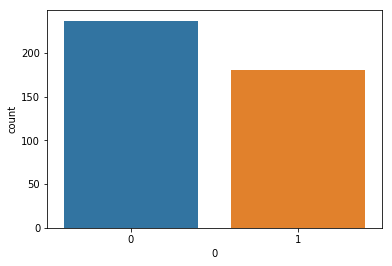

0    0.566986
1    0.433014
dtype: float64


In [57]:
# Distribution of y_preds
y_preds_nn_int = np.round(y_preds_nn).astype(np.int8)
sns.countplot(x=0, data=pd.DataFrame(y_preds_nn_int))
plt.show()

print(pd.Series(y_preds_nn_int).value_counts(normalize=True))

## 6. Create Submission

### 6-1. LightGBM

In [58]:
sub_lgbm = df_sub.copy()
sub_lgbm['Survived'] = y_preds_lgbm_int

sub_lgbm.head(10).T

,0,1,2,3,4,5,6,7,8,9
PassengerId,892,893,894,895,896,897,898,899,900,901
Survived,0,1,0,0,1,0,1,0,0,0


In [59]:
# Output csv file
sub_lgbm.to_csv(base_dir+'submit/sub_lgbm.csv', index=False)

### 6-2. XGBoost

In [60]:
sub_xgb = df_sub.copy()
sub_xgb['Survived'] = y_preds_xgb_int

sub_xgb.head(10).T

,0,1,2,3,4,5,6,7,8,9
PassengerId,892,893,894,895,896,897,898,899,900,901
Survived,0,1,0,0,1,0,1,0,1,0


In [61]:
# Output csv file
sub_xgb.to_csv(base_dir+'submit/sub_xgb.csv', index=False)

### 6-3. Neural Network

In [62]:
sub_nn = df_sub.copy()
sub_nn['Survived'] = y_preds_nn_int

sub_nn.head(10).T

,0,1,2,3,4,5,6,7,8,9
PassengerId,892,893,894,895,896,897,898,899,900,901
Survived,0,1,0,0,1,0,1,1,1,0


In [63]:
# Output csv file
sub_nn.to_csv(base_dir+'submit/sub_nn.csv', index=False)

### 6-4. Ensemble

In [64]:
y_preds_ens = (y_preds_lgbm + y_preds_xgb + y_preds_nn) / 3
y_preds_ens_int = np.round(y_preds_ens).astype(np.int8)

In [65]:
sub_ens = df_sub.copy()
sub_ens['Survived'] = y_preds_ens_int

sub_ens.head(10).T

,0,1,2,3,4,5,6,7,8,9
PassengerId,892,893,894,895,896,897,898,899,900,901
Survived,0,1,0,0,1,0,1,0,1,0


In [66]:
# Output csv file
sub_ens.to_csv(base_dir+'submit/sub_ens.csv', index=False)